In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading data
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Train data shape: (39211, 16)
Test data shape: (10000, 15)


In [3]:
# perform basic EDA
print("\nDataset Info:")
print(train_df.info())

print("\nMissing Values:")
print(train_df.isnull().sum())

print("\nStatistical Summary:")
print(train_df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
m

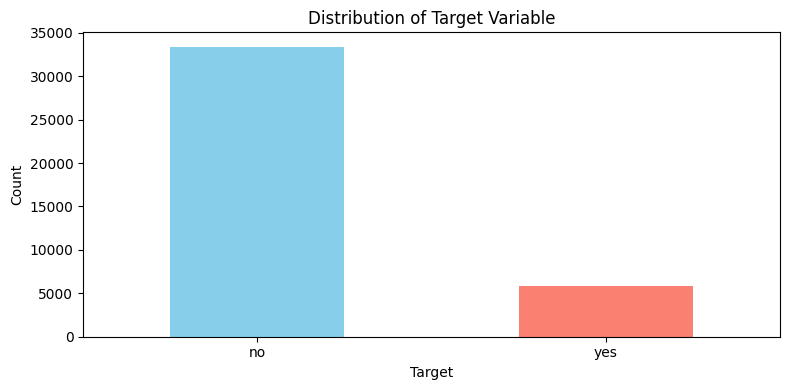

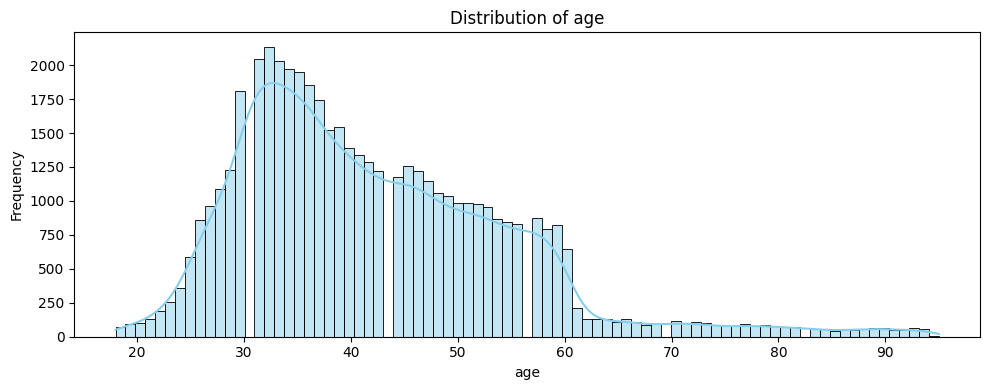

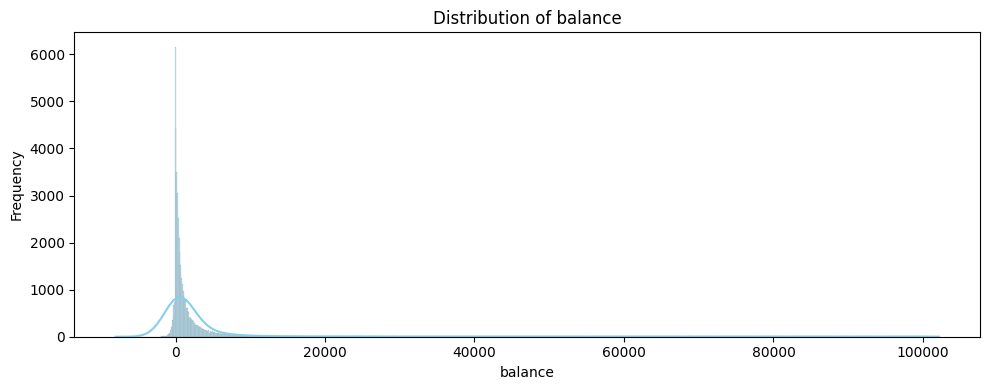

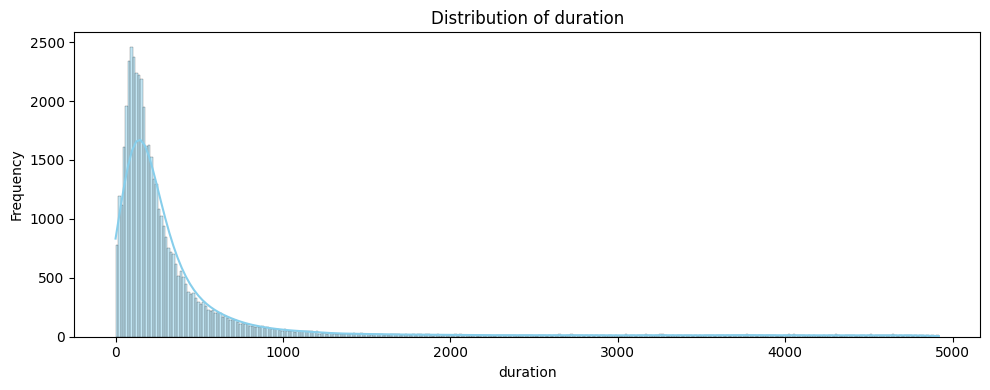

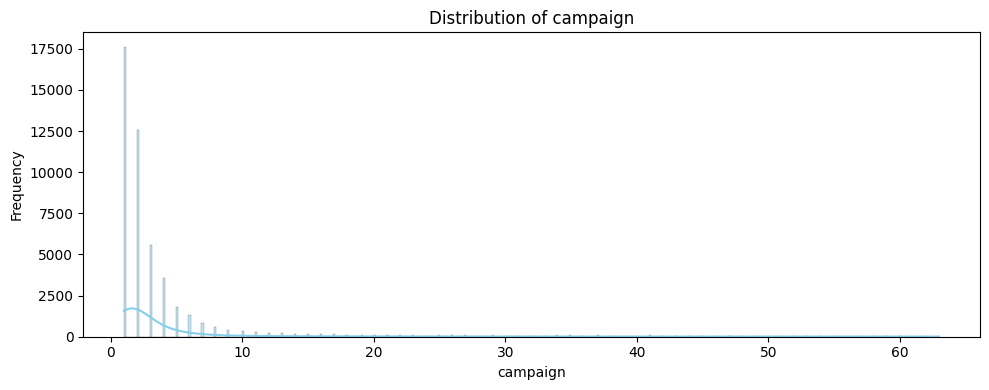

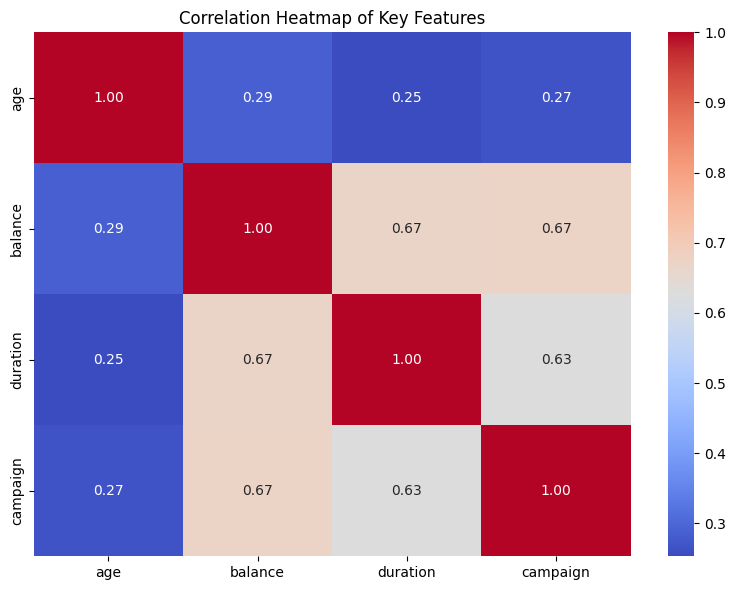

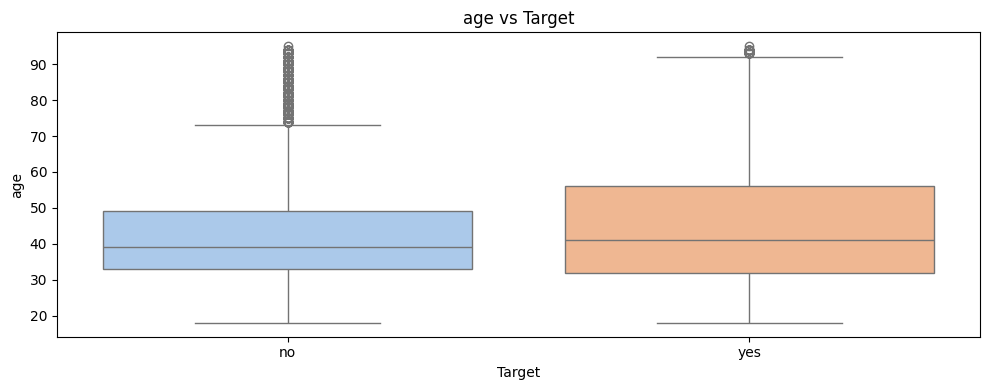

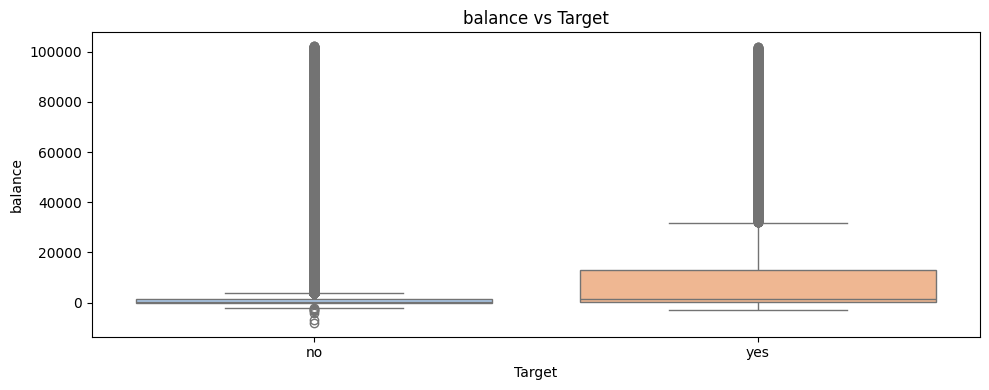

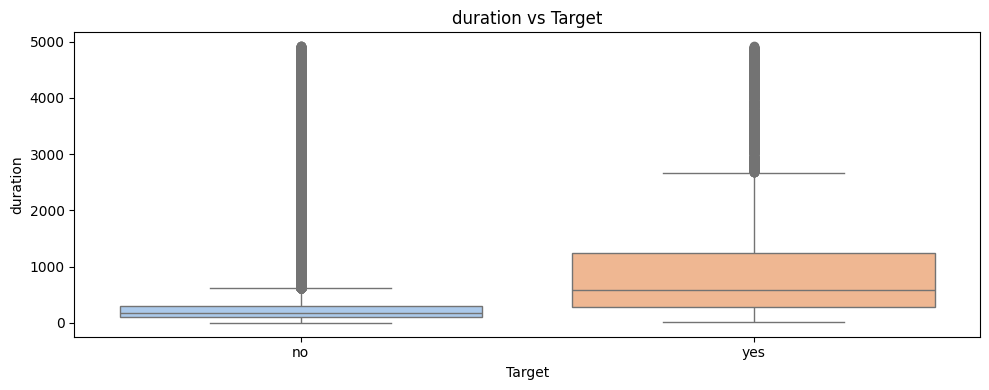

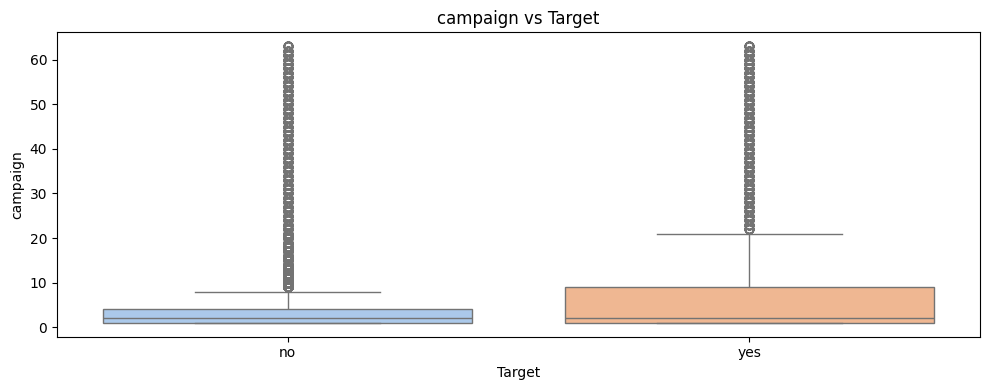

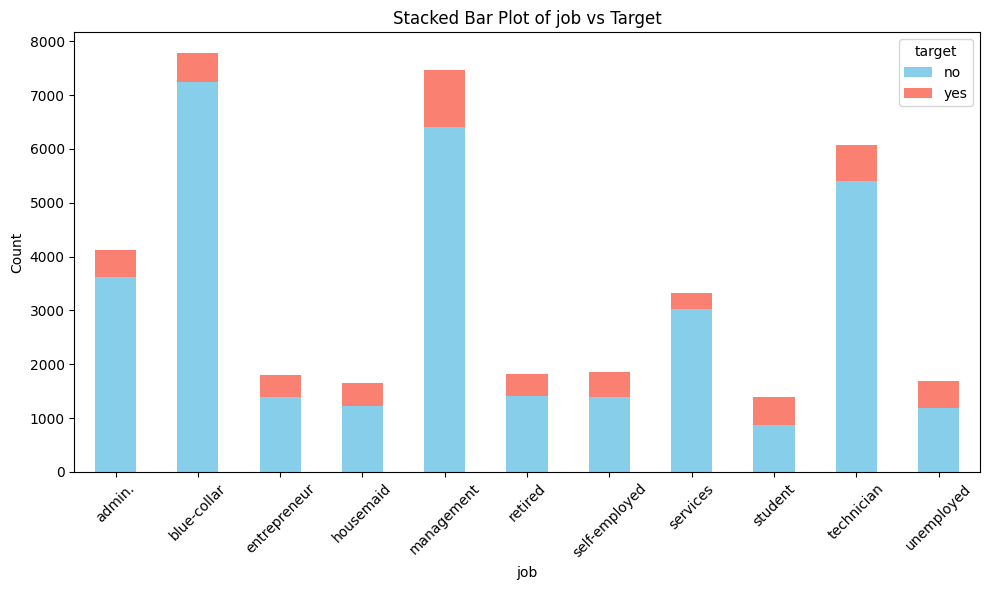

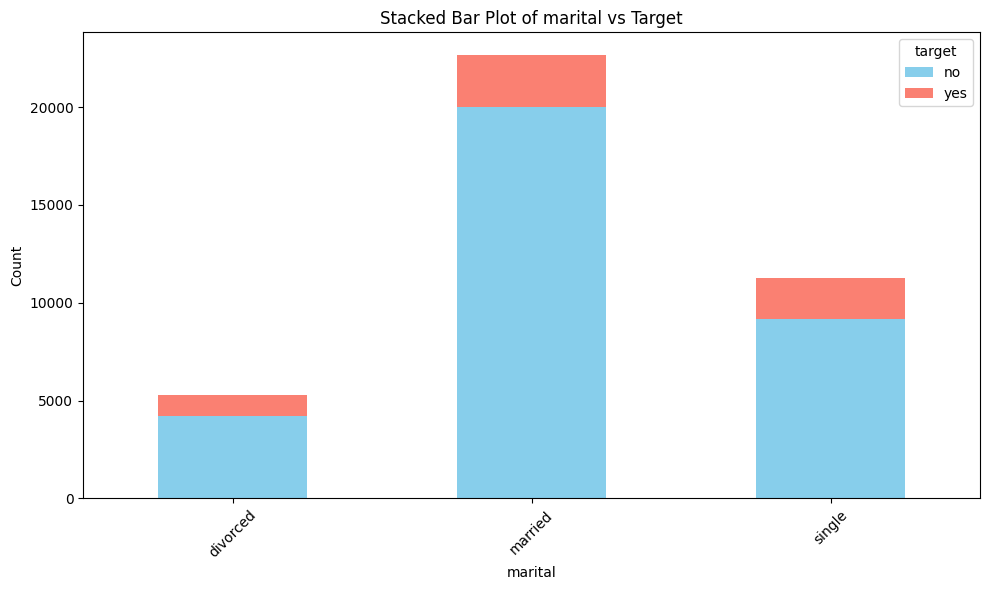

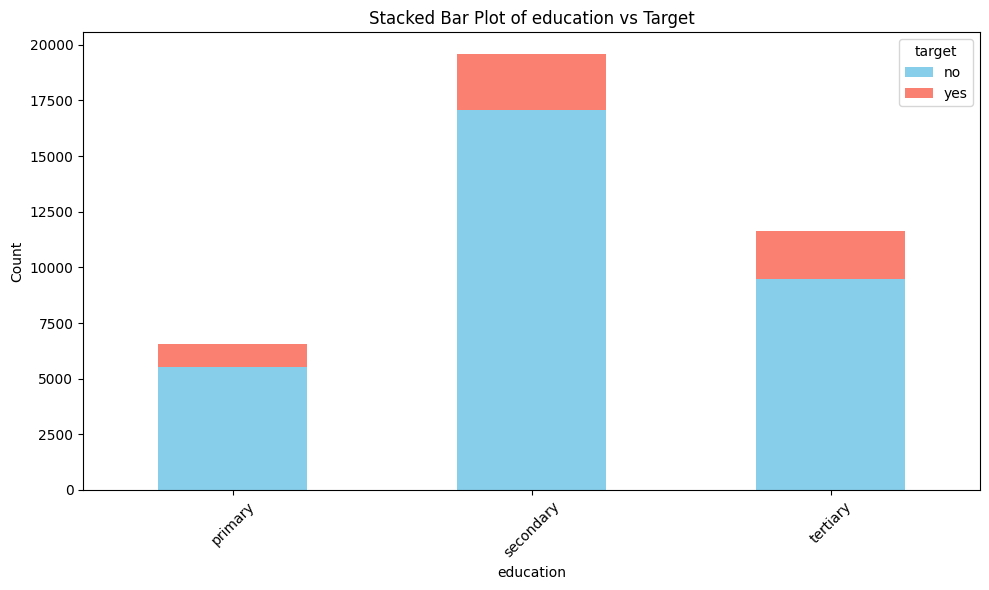

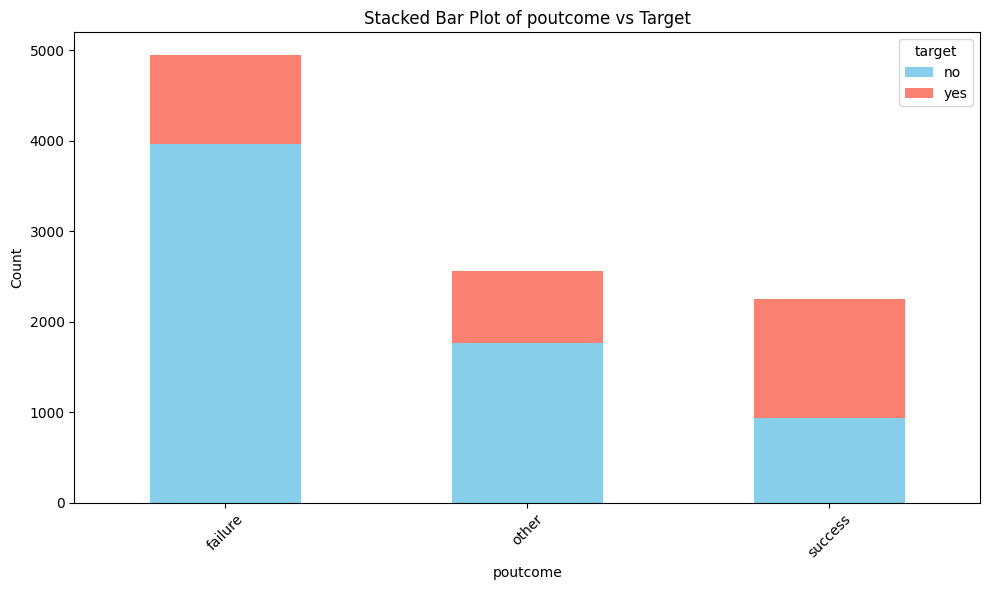

In [4]:
# Combine train and test for EDA
df = pd.concat([train_df, test_df], ignore_index=True)

# Bar Plot for Target Variable
plt.figure(figsize=(8, 4))
df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Histograms for Key Numerical Features
key_numeric_cols = ['age', 'balance', 'duration', 'campaign']
for col in key_numeric_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Correlation Heatmap for Key Numerical Features
plt.figure(figsize=(8, 6))
sns.heatmap(df[key_numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.show()

# Box Plot for Key Numerical Features vs. Target
for col in key_numeric_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='target', y=col, data=df, palette='pastel')
    plt.title(f'{col} vs Target')
    plt.xlabel('Target')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Stacked Bar Plots for Key Categorical Features
key_categorical_cols = ['job', 'marital', 'education', 'poutcome']
for col in key_categorical_cols:
    cross_tab = pd.crosstab(df[col], df['target'])
    cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
    plt.title(f'Stacked Bar Plot of {col} vs Target')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
df = pd.concat([train_df, test_df], axis=0, sort=False)
# Date processing
date_columns = df.columns[df.columns.str.contains('date', case=False)]
for date_column in date_columns:
    try:
        df[date_column] = pd.to_datetime(df[date_column])
        df[f'{date_column}_month'] = df[date_column].dt.month
        df[f'{date_column}_day'] = df[date_column].dt.day
        df[f'{date_column}_dayofweek'] = df[date_column].dt.dayofweek
        df.drop(date_column, axis=1, inplace=True)
    except:
        print(f"Error processing date column {date_column}")
        df.drop(date_column, axis=1, inplace=True)

In [6]:
# Feature engineering
if 'pdays' in df.columns:
    df['was_previously_contacted'] = (df['pdays'] != -1).astype(int)

In [7]:
# Handling binary variables
binary_cols = ['default', 'housing', 'loan']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'yes': 1, 'no': 0, 'unknown': -1})

In [8]:
# Split back
train_df = df[:len(train_df)]
test_df = df[len(train_df):]

# Prepare Data for Modeling
X_train = train_df.drop('target', axis=1)
y_train = train_df['target'].map({'yes': 1, 'no': 0})
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [9]:
# Preprocessing and Train Baseline Model
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

baseline_model.fit(X_train, y_train)
baseline_score = baseline_model.score(X_val, y_val)
print(f"Baseline model validation score: {baseline_score:.4f}")

Baseline model validation score: 0.8624


In [10]:
# Training Linear Models-SGD with Grid Search and Hyperparameter Tuning
sgd_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(random_state=42, max_iter=1000))
])

param_grid = {
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__loss': ['log_loss', 'modified_huber'],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__max_iter': [2000]
}

grid_search = GridSearchCV(sgd_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best SGD parameters:", grid_search.best_params_)
print("Best SGD score:", grid_search.best_score_)

Best SGD parameters: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__max_iter': 2000, 'classifier__penalty': 'l2'}
Best SGD score: 0.8602399046548548


In [11]:
# PCA Implementation
pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('classifier', LogisticRegression())
])

pca_pipeline.fit(X_train, y_train)
pca_score = pca_pipeline.score(X_val, y_val)
print(f"PCA model validation score: {pca_score:.4f}")

PCA model validation score: 0.8531


In [12]:
# Feature Selection
feature_selector = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=mutual_info_classif, k=10)),
    ('classifier', LogisticRegression())
])

feature_selector.fit(X_train, y_train)
selector_score = feature_selector.score(X_val, y_val)
print(f"Feature selection model validation score: {selector_score:.4f}")


Feature selection model validation score: 0.8606


In [13]:
# Train Classical Models
models = {
    'naive_bayes': GaussianNB(),
    'knn': KNeighborsClassifier(n_neighbors=3,weights='distance'),
    'svm': SVC(kernel='rbf',C=20.0,random_state=42,probability=True)
}

best_score = 0
best_model = None

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_val, y_val)
    print(f"{name} validation score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_model = pipeline

naive_bayes validation score: 0.8401
knn validation score: 0.8587
svm validation score: 0.8675


In [14]:
# Train Ensemble Models
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=2000,
        max_depth=25,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )),
    ('gb', GradientBoostingClassifier(
        n_estimators=2000,
        learning_rate=0.02,
        max_depth=10,
        subsample=0.9,
        min_samples_split=4,
        random_state=42
    )),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(400, 200, 100),
        max_iter=5000,
        learning_rate='adaptive',
        early_stopping=True,
        validation_fraction=0.2,
        random_state=42,
        alpha=0.00005
    ))
]

stacking = StackingClassifier(
    estimators=base_models + [
        ('svm', models['svm']),
        ('knn', models['knn']),
        ('nb', models['naive_bayes'])
    ],
    final_estimator=LogisticRegression(
        C=0.18,
        max_iter=5000,
        class_weight='balanced',
        random_state=42
    ),
    cv=7,
    n_jobs=-1,
    passthrough=True
)
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', stacking)
])

final_model.fit(X_train, y_train)
score = final_model.score(X_val, y_val)
print(f"Stacking ensemble validation score: {score:.4f}")

Stacking ensemble validation score: 0.8442


In [15]:
# cross-validation scoring
'''
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5)
print(f"\nCross-validation scores mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print("Individual CV scores:", [f"{score:.4f}" for score in cv_scores])
'''
# final model f-1 score
final_pred = final_model.predict(X_val)
model_score = f1_score(y_val, final_pred, average='macro')
print(f"Your model's F1 score: {model_score:.4f}")

Your model's F1 score: 0.7634


In [16]:
# Generate Submission
predictions = final_model.predict(test_df)
submission = pd.DataFrame({
    'id': range(len(test_df)),
    'target': predictions
})
submission['target'] = submission['target'].map({1: 'yes', 0: 'no'})
submission.to_csv('submission.csv', index=False)
print(f"\nSubmission file 'submission.csv' has been generated.")


Submission file 'submission.csv' has been generated.
